In [1]:
RANDOM_STATE = 2387

In [2]:
import numpy as np
import pandas as pd
import torch
from data.featurization.dgl_Graph import DGL_Graph
from model.dgl.GAT import GAT
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [3]:
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

In [4]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
trn = pd.read_csv("../data/processed/trn.csv")
tst_08SC = pd.read_csv("../data/processed/tst.08SC.csv")
tst1_19SC = pd.read_csv("../data/processed/tst.19SC.1.csv")
tst2_19SC = pd.read_csv("../data/processed/tst.19SC.2.csv")

trn_y, trn_X = trn["Solubility"], trn["SMILES"]
tst_08SC_y, tst_08SC_X = tst_08SC["Solubility"], tst_08SC["SMILES"]
tst1_19SC_y, tst1_19SC_X = tst1_19SC["Solubility"], tst1_19SC["SMILES"]
tst2_19SC_y, tst2_19SC_X = tst2_19SC["Solubility"], tst2_19SC["SMILES"]

In [6]:
featurizer = DGL_Graph(
    graph_type="BI_GRAPH",
    featurize_type="Canonical",
    self_loop=True
)
trn_X = featurizer.convert(trn_X)
tst_08SC_X = featurizer.convert(tst_08SC_X)
tst1_19SC_X = featurizer.convert(tst1_19SC_X)
tst2_19SC_X = featurizer.convert(tst2_19SC_X)

In [21]:
tune_space = {
    "num_heads": hp.randint("num_heads", 2, 6),
    "hidden_feats": hp.choice("hidden_feats", [[64], [64, 32], [128, 64, 32], [64, 64], [128, 64]]),
    "feat_drops": hp.uniform("feat_drops", 0, 1),
    "attn_drops": hp.uniform("attn_drops", 0, 1),
    "alphas": hp.uniform("alphas", 0, 1),
    "residuals": hp.choice("residuals", [True, False]),
    "agg_modes": hp.choice("agg_modes", ["flatten", "mean"]),
    "biases": hp.choice("biases", [True, False]),
    "lr": hp.choice("lr", [0.1, 0.01, 0.001]),
    "weight_decay": hp.uniform("weight_decay", 0, 1),
    "batch_size": 4096,
}

In [22]:
def tune_obj(space):
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    rmse = []

    for trn_idx, val_idx in kf.split(trn_X):
        tX, vX = trn_X[trn_idx], trn_X[val_idx]
        ty, vy = trn_y[trn_idx], trn_y[val_idx]

        model = GAT(
            n_tasks=1,
            in_feats=featurizer.get_node_feat_size(),
            num_heads=space["num_heads"],
            hidden_feats=space["hidden_feats"],
            feat_drops=space["feat_drops"],
            attn_drops=space["attn_drops"],
            alphas=space["alphas"],
            residuals=space["residuals"],
            agg_modes=space["agg_modes"],
            biases=space["biases"],
            classifier_hidden_feats=128,
            classifier_dropout=0,
            predictor_hidden_feats=128,
            predictor_dropout=0,
            lr=space["lr"],
            weight_decay=space["weight_decay"],
            batch_size=4096,
        )
        scores = model.fit(tX, ty,
                           val_X=vX, val_y=vy,
                           epochs=400, min_epochs=200, early_stop_epochs=10, verbose=False)
        rmse.append(scores["rmse"][-1])

    return {"loss": np.mean(rmse), 'status': STATUS_OK}

In [ ]:
trials = Trials()
best_params = fmin(
    fn=tune_obj,
    space=tune_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

In [14]:
best_params

{'num_heads': 5,
 'hidden_feats': [256, 128],
 'feat_drops': 1e-06,
 'attn_drops': 1e-06,
 'alphas': 0.6721585674551578,
 'residuals': False,
 'agg_modes': 'flatten',
 'biases': True,
 'lr': 0.001,
 'weight_decay': 1e-06,
 'batch_size': 4096}

In [31]:
best_params = {
    "num_heads": 5,
    "hidden_feats": [128, 64],
    "feat_drops": 0.01,
    "attn_drops": 0.01,
    "alphas": 0.6721585674551578,
    "residuals": False,
    "agg_modes": "flatten",
    "biases": True,
    "lr": 0.001,
    "weight_decay": 0.01,
    "batch_size": 4096,
}

In [66]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

pred_19t1, pred_19t2, pred_08t = [], [], []

for trn_idx, val_idx in kf.split(trn_X):
    tX, vX = trn_X[trn_idx], trn_X[val_idx]
    ty, vy = trn_y[trn_idx], trn_y[val_idx]

    model = GAT(
        n_tasks=1,
        in_feats=featurizer.get_node_feat_size(),
        num_heads=best_params["num_heads"],
        hidden_feats=best_params["hidden_feats"],
        feat_drops=best_params["feat_drops"],
        attn_drops=best_params["attn_drops"],
        alphas=best_params["alphas"],
        residuals=best_params["residuals"],
        agg_modes=best_params["agg_modes"],
        biases=best_params["biases"],
        classifier_hidden_feats=256,
        classifier_dropout=0,
        predictor_hidden_feats=256,
        predictor_dropout=0,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        batch_size=4096,
    )

    scores = model.fit(tX, ty, val_X=vX, val_y=vy, epochs=600, min_epochs=200, early_stop_epochs=10)

    pred_19t1.append(model.predict(tst1_19SC_X).cpu())
    pred_19t2.append(model.predict(tst2_19SC_X).cpu())
    pred_08t.append(model.predict(tst_08SC_X).cpu())

[DEVICE] cuda


 40%|███▉      | 238/600 [00:13<00:20, 17.31it/s, trn_loss:0.075 val_loss:0.323 rmse:0.863 r2:0.808]


[DEVICE] cuda


 38%|███▊      | 230/600 [00:13<00:21, 17.22it/s, trn_loss:0.097 val_loss:0.210 rmse:0.687 r2:0.876] 


[DEVICE] cuda


 43%|████▎     | 260/600 [00:14<00:19, 17.75it/s, trn_loss:0.068 val_loss:0.212 rmse:0.730 r2:0.867] 


[DEVICE] cuda


 39%|███▉      | 236/600 [00:13<00:20, 17.64it/s, trn_loss:0.108 val_loss:0.283 rmse:0.814 r2:0.826] 


[DEVICE] cuda


 36%|███▋      | 218/600 [00:12<00:21, 17.61it/s, trn_loss:0.090 val_loss:0.632 rmse:1.245 r2:0.600]


In [67]:
pred_19t1 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t1, 1)]
pred_19t2 = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_19t2, 1)]
pred_08t = [torch.mean(pred_i).item() for pred_i in torch.cat(pred_08t, 1)]

In [68]:
performance = {
    "2019SC TST1 (RMSE)": mean_squared_error(tst1_19SC_y, pred_19t1, squared=False),
    "2019SC TST2 (RMSE)": mean_squared_error(tst2_19SC_y, pred_19t2, squared=False),
    "2008SC TST  (RMSE)": mean_squared_error(tst_08SC_y, pred_08t, squared=False),
    "2019SC TST1 (R^2)": r2_score(tst1_19SC_y, pred_19t1),
    "2019SC TST2 (R^2)": r2_score(tst2_19SC_y, pred_19t2),
    "2008SC TST  (R^2)": r2_score(tst_08SC_y, pred_08t),
}
performance

{'2019SC TST1 (RMSE)': 0.6475558703310463,
 '2019SC TST2 (RMSE)': 1.5409703064237568,
 '2008SC TST  (RMSE)': 0.6972779505704176,
 '2019SC TST1 (R^2)': 0.6546421679198622,
 '2019SC TST2 (R^2)': 0.40973608084035196,
 '2008SC TST  (R^2)': 0.7359958114002327}

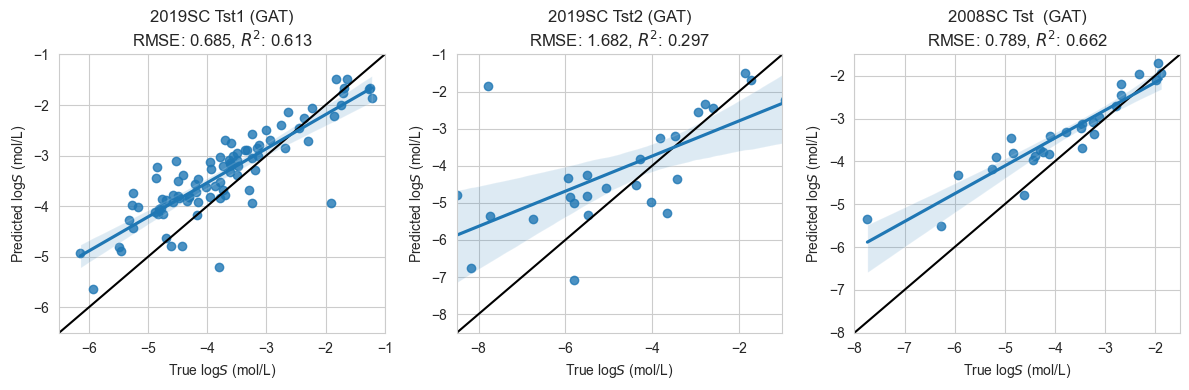

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "GAT"
min_ax1, max_ax1 = -6.5, -1
min_ax2, max_ax2 = -8.5, -1
min_ax3, max_ax3 = -8, -1.5

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.lineplot(x=[min_ax1, max_ax1], y=[min_ax1, max_ax1], ax=ax1, color="black")
sns.lineplot(x=[min_ax2, max_ax2], y=[min_ax2, max_ax2], ax=ax2, color="black")
sns.lineplot(x=[min_ax3, max_ax3], y=[min_ax3, max_ax3], ax=ax3, color="black")

sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst1_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t1
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax1
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst2_19SC_y.values,
        "Predicted log$S$ (mol/L)": pred_19t2
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax2
)
sns.regplot(
    data=pd.DataFrame({
        "True log$S$ (mol/L)": tst_08SC_y.values,
        "Predicted log$S$ (mol/L)": pred_08t
    }),
    x="True log$S$ (mol/L)",
    y="Predicted log$S$ (mol/L)",
    ax=ax3
)

ax1.set_xlim(min_ax1, max_ax1)
ax1.set_ylim(min_ax1, max_ax1)
ax2.set_xlim(min_ax2, max_ax2)
ax2.set_ylim(min_ax2, max_ax2)
ax3.set_xlim(min_ax3, max_ax3)
ax3.set_ylim(min_ax3, max_ax3)

ax1.set_title(f"2019SC Tst1 ({model_name})\n"
              f"RMSE: {performance['2019SC TST1 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST1 (R^2)']:.3f}")
ax2.set_title(f"2019SC Tst2 ({model_name})\n"
              f"RMSE: {performance['2019SC TST2 (RMSE)']:.3f}, "
              f"$R^2$: {performance['2019SC TST2 (R^2)']:.3f}")
ax3.set_title(f"2008SC Tst  ({model_name})\n"
              f"RMSE: {performance['2008SC TST  (RMSE)']:.3f}, "
              f"$R^2$: {performance['2008SC TST  (R^2)']:.3f}")

# plt.axis("equal")
plt.tight_layout()